# Task 2 — TSLA Time Series Forecasting (ARIMA/SARIMA vs Multivariate LSTM)

This notebook is the **only notebook for Task 2**. **All modeling and artifact generation is done via scripts**:
- `scripts/03_task2_make_splits_and_features.py`
- `scripts/04_task2_train_arima.py`
- `scripts/05_task2_train_lstm.py`
- `scripts/06_task2_compare_models.py`

## Key modeling choice (returns-primary)
- We forecast **next-day log returns** (`logret_1d`) rather than raw price levels.
- We optionally reconstruct a **price path** from predicted returns for stakeholder visualization.

## Required deliverables shown here
1. Chronological split with cutoff on last trading day of 2024 (`split_info.json`)
2. ARIMA/SARIMA model specification (`arima_params.json`)
3. LSTM architecture + training configuration (`lstm_architecture.json`)
4. Forecast CSVs aligned to test dates (`tsla_arima_forecast.csv`, `tsla_lstm_forecast.csv`, merged)
5. Performance metrics table with MAE/RMSE/MAPE (`model_comparison.csv`)


In [1]:
import os
import sys
import json
from pathlib import Path
import importlib

import pandas as pd
import matplotlib.pyplot as plt


def _find_repo_root(start: Path) -> Path:
    """Walk upward until we find a folder containing `src/` and at least one of `data/` or `outputs/`."""
    start = start.resolve()
    for candidate in [start, *start.parents]:
        if (candidate / "src").is_dir() and ((candidate / "data").exists() or (candidate / "outputs").exists()):
            return candidate
    return start


REPO_ROOT = _find_repo_root(Path.cwd())

# Make imports and relative paths work consistently from notebooks/
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
os.chdir(REPO_ROOT)

from src import config as config
config = importlib.reload(config)

print("Repo root:", REPO_ROOT)
print("Notebook working directory (after chdir):", os.getcwd())
print("config file:", getattr(config, "__file__", None))
print("Target col (returns-primary):", getattr(config, "TASK2_TARGET_COL", None))
print("Price col (for features/reconstruction):", getattr(config, "TASK2_PRICE_COL", None))
print("Split info path:", getattr(config, "TASK2_SPLIT_INFO_PATH", None))
print("ARIMA params path:", getattr(config, "TASK2_ARIMA_PARAMS_PATH", None))
print("LSTM arch path:", getattr(config, "TASK2_LSTM_ARCH_PATH", None))


Repo root: D:\Python\Week 9\portfolio-optimization
Notebook working directory (after chdir): D:\Python\Week 9\portfolio-optimization
config file: D:\Python\Week 9\portfolio-optimization\src\config.py
Target col (returns-primary): logret_1d
Price col (for features/reconstruction): adj_close
Split info path: outputs/task2/metrics/split_info.json
ARIMA params path: outputs/task2/metrics/arima_params.json
LSTM arch path: outputs/task2/metrics/lstm_architecture.json


## 1) Load chronological split information

This documents the cutoff dates used for TRAIN / VAL / TEST.

In [2]:
if not os.path.exists(config.TASK2_SPLIT_INFO_PATH):
    raise FileNotFoundError(
        f"Missing {config.TASK2_SPLIT_INFO_PATH}. Run: python scripts/03_task2_make_splits_and_features.py"
    )

with open(config.TASK2_SPLIT_INFO_PATH, 'r', encoding='utf-8') as f:
    split_info = json.load(f)

split_info

{'asset': 'TSLA',
 'split_year': 2024,
 'val_year': 2023,
 'cutoff_date_val': '2023-12-29',
 'cutoff_date_test': '2024-12-31',
 'n_total': 2775,
 'n_train': 2264,
 'n_val': 252,
 'n_test': 259}

## 2) Verify feature splits exist (train/val/test)

These are generated by `scripts/03_task2_make_splits_and_features.py`.

In [3]:
paths = [
    config.TASK2_FEATURES_TRAIN_PATH,
    config.TASK2_FEATURES_VAL_PATH,
    config.TASK2_FEATURES_TEST_PATH,
]
for p in paths:
    print(p, 'OK' if os.path.exists(p) else 'MISSING')

missing = [p for p in paths if not os.path.exists(p)]
if missing:
    raise FileNotFoundError('Missing feature splits:\n' + '\n'.join(missing))

train_feat = pd.read_parquet(config.TASK2_FEATURES_TRAIN_PATH)
val_feat = pd.read_parquet(config.TASK2_FEATURES_VAL_PATH)
test_feat = pd.read_parquet(config.TASK2_FEATURES_TEST_PATH)

print('train_feat:', train_feat.shape)
print('val_feat:', val_feat.shape)
print('test_feat:', test_feat.shape)
display(train_feat.head())

data/task2/features/tsla_features_train.parquet OK
data/task2/features/tsla_features_val.parquet OK
data/task2/features/tsla_features_test.parquet OK
train_feat: (2205, 13)
val_feat: (252, 13)
test_feat: (259, 13)


,date,adj_close,open,high,low,close,volume,ret_1d,logret_1d,vol_20d,sma_20,sma_60,vol_chg_1d
0,2015-03-30,12.704667,12.390,12.816667,12.120000,12.704667,151342500,0.030108,0.029664,0.022022,12.992333,13.514367,0.172530
1,2015-03-31,12.584667,12.902,12.917333,12.560667,12.584667,75399000,-0.009445,-0.009490,0.021866,12.956367,13.480433,-0.501799
2,2015-04-01,12.506000,12.580,12.820000,12.403333,12.506000,56919000,-0.006251,-0.006271,0.021500,12.906867,13.455433,-0.245096
3,2015-04-02,12.733333,12.682,12.882000,12.666667,12.733333,75156000,0.018178,0.018015,0.022000,12.874767,13.432900,0.320403
4,2015-04-06,13.540000,13.200,13.850000,13.166667,13.540000,186837000,0.063351,0.061425,0.024933,12.905500,13.424178,1.485989


## 3) ARIMA/SARIMA model specification

Loaded from `arima_params.json` produced by the ARIMA training script.

In [4]:
from IPython.display import display
import json
import os

if not os.path.exists(config.TASK2_ARIMA_PARAMS_PATH):
    print("ARIMA params not found. Run:")
    print("  python scripts/04_task2_train_arima.py")
else:
    with open(config.TASK2_ARIMA_PARAMS_PATH, "r", encoding="utf-8") as f:
        arima_params = json.load(f)

    display(arima_params)  # best for notebooks
    # or:
    # print(json.dumps(arima_params, indent=2))

print("ARIMA params path =", config.TASK2_ARIMA_PARAMS_PATH)
print("Exists? ", os.path.exists(config.TASK2_ARIMA_PARAMS_PATH))




{'asset': 'TSLA',
 'target_col': 'logret_1d',
 'strategy': 'walk_forward',
 'refit_each_step': False,
 'refit_every': 20,
 'seasonal': False,
 'm': 5,
 'order': [0, 0, 0],
 'seasonal_order': [0, 0, 0, 0],
 'aic': -10276.096429238092,
 'bic': -10264.282598260736,
 'metrics': {'MAE': 0.02907958113767477,
  'RMSE': 0.0395891536488815,
  'MAPE_pct': 117.79276511122193},
 'split': 'test'}

ARIMA params path = outputs/task2/metrics/arima_params.json
Exists?  True


## 4) LSTM architecture + training configuration

Loaded from `lstm_architecture.json` produced by the LSTM training script.

In [5]:
if not os.path.exists(config.TASK2_LSTM_ARCH_PATH):
    raise FileNotFoundError(
        f"Missing {config.TASK2_LSTM_ARCH_PATH}. Run: python scripts/05_task2_train_lstm.py"
    )

with open(config.TASK2_LSTM_ARCH_PATH, 'r', encoding='utf-8') as f:
    lstm_arch = json.load(f)

lstm_arch

{'run': {'lookback': 60,
  'horizon': 1,
  'feature_cols': ['open',
   'high',
   'low',
   'close',
   'adj_close',
   'volume',
   'ret_1d',
   'logret_1d',
   'vol_20d',
   'sma_20',
   'sma_60',
   'vol_chg_1d'],
  'target_col': 'logret_1d',
  'price_col': 'adj_close',
  'scaler_type': 'minmax',
  'epochs': 30,
  'batch_size': 32,
  'learning_rate': 0.001,
  'units_1': 64,
  'units_2': 32,
  'dropout': 0.2,
  'rec_dropout': 0.0},
 'history_last': {'loss': 0.001352784689515829,
  'val_loss': 0.0009394984808750451},
 'metrics': {'MAE': 0.02948704206139592,
  'RMSE': 0.03986632499657204,
  'MAPE_pct': 236.066753634152}}

## 5) Load forecasts (TEST) — aligned to test dates

Important: `tsla_lstm_forecast.csv` is now **returns-space** (y_true and pred are log returns).

Optional: `*_forecast_price.csv` contains the reconstructed price path.

In [6]:
def load_if_exists(path: str):
    if os.path.exists(path):
        return pd.read_csv(path)
    return None

arima_fc = load_if_exists(config.TASK2_ARIMA_FORECAST_PATH)
lstm_fc = load_if_exists(config.TASK2_LSTM_FORECAST_PATH)

print('ARIMA forecast:', 'OK' if arima_fc is not None else 'MISSING')
print('LSTM forecast:', 'OK' if lstm_fc is not None else 'MISSING')

if lstm_fc is None:
    raise FileNotFoundError(
        f"Missing {config.TASK2_LSTM_FORECAST_PATH}. Run: python scripts/05_task2_train_lstm.py"
    )

display(lstm_fc.head())
print('LSTM forecast rows:', len(lstm_fc))

ARIMA forecast: OK
LSTM forecast: OK


,date,y_true,lstm_pred
0,2025-01-02,0.078955,-0.001748
1,2025-01-03,0.001485,-0.003136
2,2025-01-06,-0.041451,-0.004413
3,2025-01-07,0.001470,-0.006235
4,2025-01-08,-0.000507,-0.007879


LSTM forecast rows: 258


### Optional: load price reconstruction outputs

In [7]:
lstm_price = load_if_exists(getattr(config, 'TASK2_LSTM_FORECAST_PRICE_PATH', ''))
if lstm_price is not None:
    display(lstm_price.head())
    print('Loaded reconstructed price path:', getattr(config, 'TASK2_LSTM_FORECAST_PRICE_PATH', None))
else:
    print('No reconstructed price file found (optional).')

print("TASK2_LSTM_FORECAST_PRICE_PATH =", getattr(
    config, "TASK2_LSTM_FORECAST_PRICE_PATH", None))

,date,p0,y_true_price,y_pred_price
0,2025-01-02,253.179993,273.980166,252.737897
1,2025-01-03,253.179993,274.387348,251.946657
2,2025-01-06,253.179993,263.246305,250.837222
3,2025-01-07,253.179993,263.633483,249.278140
4,2025-01-08,253.179993,263.499969,247.321774


Loaded reconstructed price path: outputs/task2/forecasts/tsla_lstm_forecast_price.csv
TASK2_LSTM_FORECAST_PRICE_PATH = outputs/task2/forecasts/tsla_lstm_forecast_price.csv


## 6) Performance metrics table (model_comparison.csv)

Generated by `scripts/06_task2_compare_models.py`.

In [8]:
if not os.path.exists(config.TASK2_MODEL_COMPARISON_PATH):
    print('Missing model_comparison.csv. Run:')
    print('  python scripts/06_task2_compare_models.py')
else:
    comp = pd.read_csv(config.TASK2_MODEL_COMPARISON_PATH)
    display(comp)
    best = comp.sort_values('RMSE').iloc[0].to_dict() if 'RMSE' in comp.columns else None
    print('Best by RMSE:', best)

,model,MAE,RMSE,MAPE_pct
0,ARIMA,0.029117,0.039647,117.833444
1,ARIMA_calibrated,0.029184,0.039689,133.372637
2,LSTM_multivariate_calibrated,0.029495,0.039850,226.955307
3,LSTM_multivariate,0.029723,0.040057,240.335551


Best by RMSE: {'model': 'ARIMA', 'MAE': 0.0291172216906607, 'RMSE': 0.0396474702594922, 'MAPE_pct': 117.83344414733034}


## 7) Plot: Returns forecast vs true (TEST)

This plot is in returns space (primary).

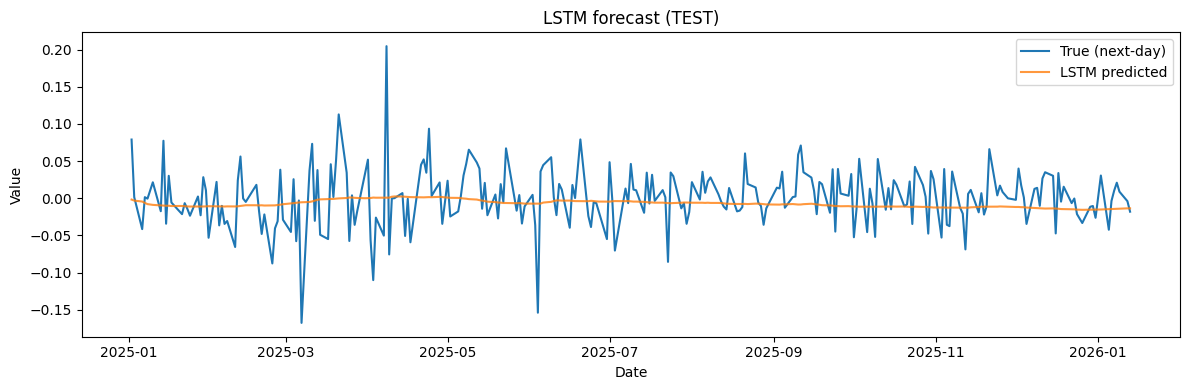

In [9]:
# Guard for notebook execution order + silence "Optional subscript" warnings:
# (This cell can be run before the cell that loads lstm_fc.)
if lstm_fc is None:
	raise RuntimeError(
		f"lstm_fc is None. Run the forecast-loading cell first (it should load {config.TASK2_LSTM_FORECAST_PATH})."
	)

date_col = getattr(config, "TASK2_DATE_COL", "date") or "date"

lstm_fc[date_col] = pd.to_datetime(lstm_fc[date_col], errors="coerce")
lstm_fc = lstm_fc.sort_values(date_col)

plt.figure(figsize=(12, 4))
plt.plot(lstm_fc[date_col], lstm_fc["y_true"], label="True (next-day)")
plt.plot(lstm_fc[date_col], lstm_fc["lstm_pred"], label="LSTM predicted", alpha=0.8)
plt.title("LSTM forecast (TEST)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

## 8) Optional plot: reconstructed price path

This is for stakeholder readability; scoring/evaluation should remain returns-primary.

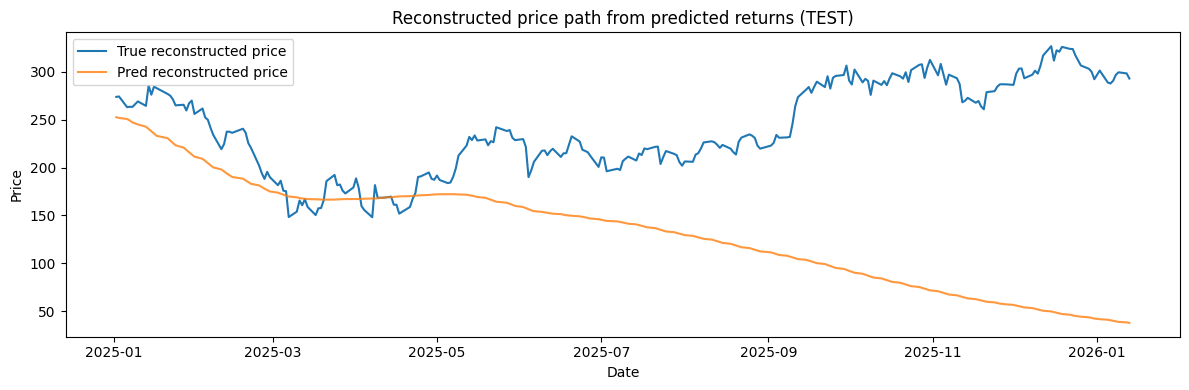

In [10]:
if lstm_price is not None:
    lstm_price[config.TASK2_DATE_COL] = pd.to_datetime(lstm_price[config.TASK2_DATE_COL])
    plt.figure(figsize=(12, 4))
    plt.plot(lstm_price[config.TASK2_DATE_COL], lstm_price['y_true_price'], label='True reconstructed price')
    plt.plot(lstm_price[config.TASK2_DATE_COL], lstm_price['y_pred_price'], label='Pred reconstructed price', alpha=0.8)
    plt.title('Reconstructed price path from predicted returns (TEST)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 9) Short discussion (rubric-friendly)

- **Why returns?** Prices are typically non-stationary; next-day returns are closer to stationary and more realistic to model.
- **Decoupled design:** features are engineered from `TASK2_PRICE_COL`, while the supervised target is `TASK2_TARGET_COL`.
- **Leakage control:** scalers are fit on TRAIN only, and sequence windows are constructed so that the prediction at time t uses only past information.
- **Price reconstruction:** predicted returns can be integrated into a price path for interpretability, but evaluation is done in returns space.